In [42]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.model_selection import *
import statsmodels.api as sm
import scipy.stats as stats

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
            
import regex as re
import requests
from bs4 import BeautifulSoup

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### Feedback from Reviewers

Research Question: not really a question? But I see what you're going for

Data Cleaning: looks like a lot done here, but I recommend clearer descriptions of the code chunks

Data Description: brief summary, can be more specific on column descriptions and contexts of each individual dataset used

Limitations: Good start, but are there any other limitations in terms of missing information/how it was collected?

EDA: Summary stats should come before the regression analysis. Good regression, but what are other relationships between variables and what do their distributions look like?

Reviewer Questions:
You can also use paired scatterplots to plot variables against each other to see if they are collinear or not

# Project Phase IV

### Introduction

It is easy to reason why the life expectancy is greater in some country than others, but why is this exactly? The leading causes of death are very different for different countries, often from differing development levels. Alongside development comes other factors that can likely influence the life expectancies of a person. These factors are often similar within countries. This begs the question, can a person's life expentancy in a given country be predicted by different metrics of their country, including violent crime rates, health care, diet, economic development, genetics, and happiness level?

By analyzing data related to country's life expectancy and these factors, we will be able to learn more about which factors influence life expectancy and which do not. Knowing which of these factors are strong can be valueable when deciding how a government should spend and write policies to increase the life span of their citizens. Knowing which factors are weak can also benefit goverment decision making by possibly reducing the amount of effort spent in these regards, if they intend to maximize life expectancy.

Lastly, one can extrapolate the country data to infer more individualized insights. If these factors on average within a given country correlate to the country having a higher life expectancy, perhaps they can also indicate ways to increase an individuals life expectancy through individual factors. Although this hypothesis is not tested in this project, it may be a starting point to explore estimating an individual's life expectancy based on their behaviors and environment .

# Data Description
- What are the observations (rows) and the attributes (columns)? <br>
On the vertical we have countries, with their respective data in the columns. Columns include `Life Expectancy`, `Homicide Rate`, `Mean years of schooling`, etc. Every column other than the country's names is a float, with null values set as -99.9 to allow for simple sorting. 
- Why was this dataset created? <br>
This dataset was created to investigate life expectancy and its relationships with macroeconimic and societal factors, such as GNI per capita, level of education, diet, happiness, etc.
- What processes might have influenced what data was observed and recorded and what was not? <br>
Our dataset consists of data gathered in recent years and in countries around the world. This has an adverse effect on the quality of the data, given that the pandemic likely negatively impacted life expectancies. It is also important to note that certain countries, especially smaller ones or those that are more protective with their data, often had missing or old data points. 
- What preprocessing was done, and how did the data come to be in the form that you are using? <br>
Much of the preprocessing had to do trying to combine datasets from varying sources, each with their own ways of categorizing data (such as UN's labelling of certain countries as "high human development", etc.) that introduce additional, not-so-relevant data into the middle of every couple of rows. Another massive issue was the various names that countries can go by. The United States, for example, can go as `USA`, `United States`, `The United States of America`, etc.
- Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). <br>
All datasets have their links attached throughout this notebook, with some copies in the `data` folder in this project.

# Data Analysis

In [64]:
df_final = pd.read_csv("data/final.csv")
df_final.head()

,Country,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
0,Albania,78.686,2.29,11.286455,14131.11039,47.51,3360.0,1.0,5.117,11.4,3
1,United Arab Emirates,78.120,0.46,12.694030,62573.59181,62.03,3314.0,1.0,6.561,18.5,4
2,Argentina,76.813,5.32,11.147269,20925.26814,109.39,3307.0,1.0,5.929,15.7,4
3,Armenia,75.224,1.69,11.330300,13157.99390,45.64,2997.0,0.0,5.283,19.9,3
4,Australia,83.200,0.89,12.726820,49238.43335,121.61,3391.0,1.0,7.183,8.6,4


### Summary Statistics

In [44]:
df_final.describe()

,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,74.181112,6.087523,9.538524,22451.396131,49.363211,2957.293578,0.541284,5.671046,17.846789,2.990826
std,6.934363,10.228273,3.063096,19594.529183,29.018068,452.467500,0.500594,1.062122,6.897471,1.084362
min,54.836000,0.260000,2.114962,1198.073924,3.780000,1908.000000,0.000000,3.145000,7.900000,1.000000
25%,70.056000,1.170000,7.192013,6589.980037,20.340000,2662.000000,0.000000,4.934000,11.000000,2.000000
50%,75.387805,2.200000,10.427910,15241.914650,53.490000,3019.000000,1.000000,5.813000,17.800000,3.000000
75%,79.208000,5.370000,12.191084,37931.303590,73.010000,3322.000000,1.000000,6.317000,22.600000,4.000000
max,84.615610,52.020000,14.090967,84649.474670,121.610000,3885.000000,1.000000,7.842000,42.700000,4.000000


### Collinearity test

Here we plot the collinearity of each column with each other. Note the linearity between factors such as income and life expectancy. On the other hand, homicide rate seems to be weakly relatd to the others.

<AxesSubplot:>

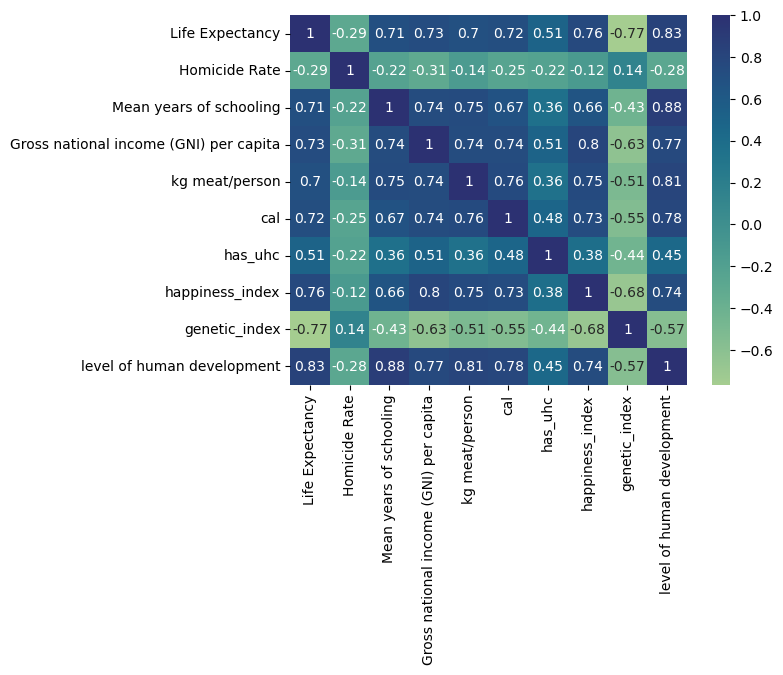

In [45]:
collinearity_matrix = df_final.iloc[:,1:].corr()
sns.heatmap(collinearity_matrix, xticklabels=collinearity_matrix.columns,yticklabels=collinearity_matrix.columns,cmap="crest", annot=True)

# Preregistered Analyses

## Do people that eat more live longer?
   * H0: People from a country that has a higher consumption live as long as others on average.
   * HA: People from countries that eat more on average live longer than those from countries with less consumption. 

In [46]:
df_final = pd.read_csv("data/final.csv")
df_h1 = df_final[["Life Expectancy","cal","Country"]].sort_values('cal')
df_h1.head()

,Life Expectancy,cal,Country
108,61.738,1908.0,Zimbabwe
102,63.713,1981.0,Uganda
107,64.194,2002.0,Zambia
70,61.387,2103.0,Mozambique
99,71.301,2109.0,Tajikistan


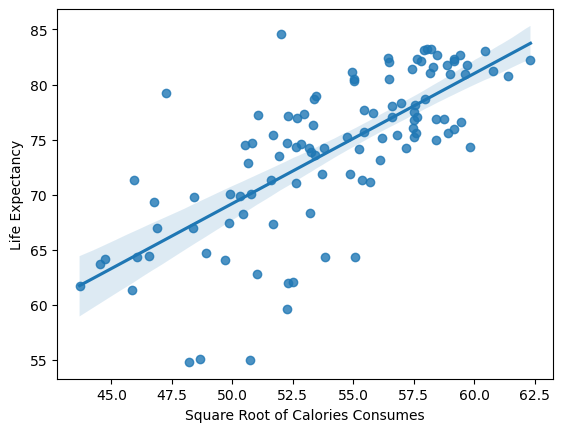

Slope of Model: [1.14425723] 
Intercept of Model: 11.827876356512661
Train RMSE: 5.051052218121081 
Test RMSE: 3.5655259656815677


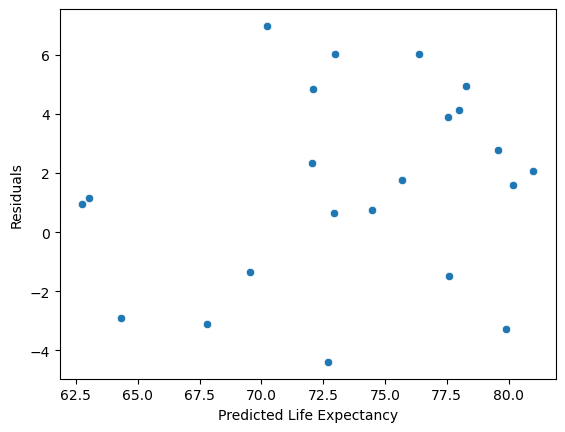

                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.546e+04
Date:                Sat, 19 Nov 2022   Prob (F-statistic):                   4.70e-130
Time:                        23:04:18   Log-Likelihood:                         -326.59
No. Observations:                 109   AIC:                                      655.2
Df Residuals:                     108   BIC:                                      657.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [47]:
#Used sqrt transformation because data showed strong curve
X = np.sqrt(df_h1["cal"].to_numpy().reshape(-1,1))
y = (df_h1["Life Expectancy"])
sns.regplot(x = X,y = y).set(xlabel='Square Root of Calories Consumes', ylabel='Life Expectancy')
plt.show()
calories_train, calories_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2, random_state=10)
model_h1 = LinearRegression().fit(calories_train,exp_train)
train_predictions = model_h1.predict(calories_train)
test_predictions = model_h1.predict(calories_test)
train_residuals = exp_train - train_predictions
test_residuals = exp_test - test_predictions
print("Slope of Model:",model_h1.coef_,"\nIntercept of Model:",model_h1.intercept_)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse,)
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()
OLS_model_h1 = sm.OLS(y, X).fit()
print(OLS_model_h1.summary())
print("\nRight-sided P-Value at 97.5% CL:",OLS_model_h1.t_test(1).pvalue)

After transforming the calorie data by square rooting it, our linear regression yields an R squared value of 0.996, suggesting very strong correlation between the square root of calories consumed on average by a country and that country's life expectancy. Our train RMSE is higher than our test RMSE which also suggests that our model is not overfitting. Additionally, when running a correlation test to analyze our hypothesis, we can reject the null hypothesis and predict that countries with higher average calorie consumption have higher life expectancies with a confidence level of 97.5%. Because our two-sided test with CL 95% yields a p-value of approximately 0, we can conclude that our right-side test would have the same p-value with a CL of 97.5%. This gives us a type I error proability of 2.5%. Our model intercept suggests that someone who eats 0 calories a day will live a predicted 10 years, which is an oddity of our model that is unrealistic and clearly untrue. Our slope suggests that for each square root calorie increases the life expectancy prediction by 1.18 years.

## Are more educated people (in terms of years of schooling) living longer?
   * H0: A country’s average education level does not affect their citizens’ life expectancies.
   * HA: People from countries with higher average education levels live longer. 

In [48]:
df_h2 = df_final[["Life Expectancy","Mean years of schooling","Country"]].sort_values('Mean years of schooling')
df_h2.head()

,Life Expectancy,Mean years of schooling,Country
9,61.981,2.114962,Burkina Faso
75,62.792,2.116717,Niger
92,68.213,2.937938,Senegal
70,61.387,3.197642,Mozambique
31,66.953,3.201521,Ethiopia


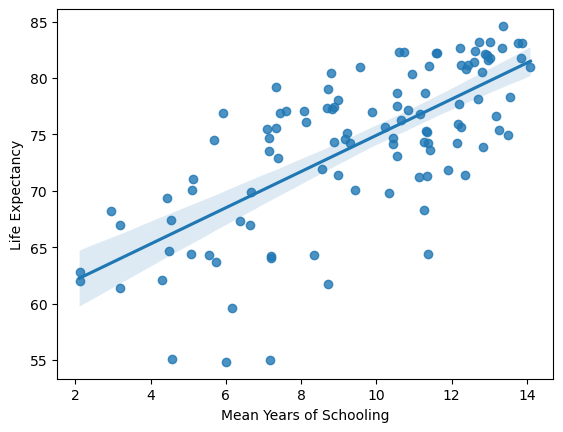

Slope of Model: [1.73537419] 
Intercept of Model: 57.2440364661451
Train RMSE: 5.041004855071486 
Test RMSE: 4.286073970760854


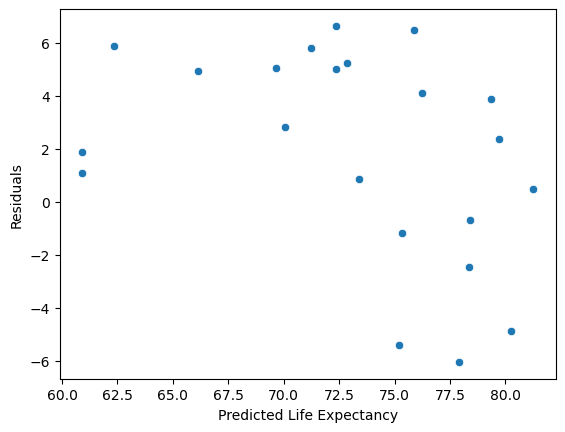

                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              1630.
Date:                Sat, 19 Nov 2022   Prob (F-statistic):                    5.54e-67
Time:                        23:04:19   Log-Likelihood:                         -473.13
No. Observations:                 109   AIC:                                      948.3
Df Residuals:                     108   BIC:                                      951.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [49]:
X = (df_h2["Mean years of schooling"].to_numpy().reshape(-1,1))
y = (df_h2["Life Expectancy"])
sns.regplot(x = X,y = y).set(xlabel='Mean Years of Schooling', ylabel='Life Expectancy')
plt.show()
schooling_train, schooling_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2, random_state=18)
model_h2 = LinearRegression().fit(schooling_train,exp_train)
train_predictions = model_h2.predict(schooling_train)
test_predictions = model_h2.predict(schooling_test)
train_residuals = exp_train - train_predictions
test_residuals = exp_test - test_predictions
print("Slope of Model:",model_h2.coef_,"\nIntercept of Model:",model_h2.intercept_)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse,)
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()
OLS_model_h2 = sm.OLS(y, X).fit()
print(OLS_model_h2.summary())
print("\nRight-sided P-Value at 97.5% CL:",OLS_model_h2.t_test(1).pvalue)

Our linear regression yields an R squared value of 0.938, suggesting strong correlation between the mean years of schooling by a country and that country's life expectancy. Our train RMSE is higher than our test RMSE which also suggests that our model is not overfitting. Additionally, when running a correlation test to analyze our hypothesis, we can reject the null hypothesis and predict that countries with longer average schooling have higher life expectancies with a confidence level of 97.5%. Because our two-sided test with CL 95% yields a p-value of approximately 0, we can conclude that our right-side test would have the same p-value with a CL of 97.5%. This gives us a type I error probability of 2.5%. The model intercepts predicts that a country with 0 years of average schooling would have a life expectancy of 57 years. The model also predicts that each one year increase in a country's average education will increase their life expectancy by 1.74 years.

## Do people in first world countries (countries with higher gross national income) live longer?
##### Adapted from Hypothesis 3 in Phase 3
   * H0: Economic development (GNI) does not affect longevity. 
   * HA: People in more economically developed countries live longer than people in developing countries.

In [50]:
df_h3 = df_final[["Life Expectancy","Gross national income (GNI) per capita","Country"]].sort_values("Gross national income (GNI) per capita")
df_h3.head()

,Life Expectancy,Gross national income (GNI) per capita,Country
70,61.387,1198.073924,Mozambique
75,62.792,1239.866936,Niger
56,64.423,1288.742350,Liberia
72,64.694,1465.635064,Malawi
93,55.066,1621.512579,Sierra Leone


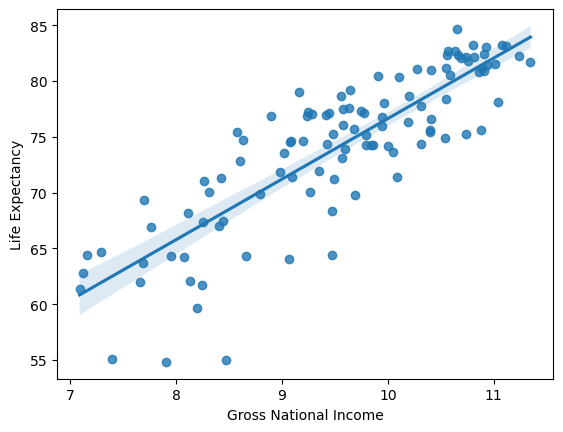

Slope of Model: [5.3004731] 
Intercept of Model: 23.821047166851173
Train RMSE: 3.538745187233812 
Test RMSE: 4.186771674461889


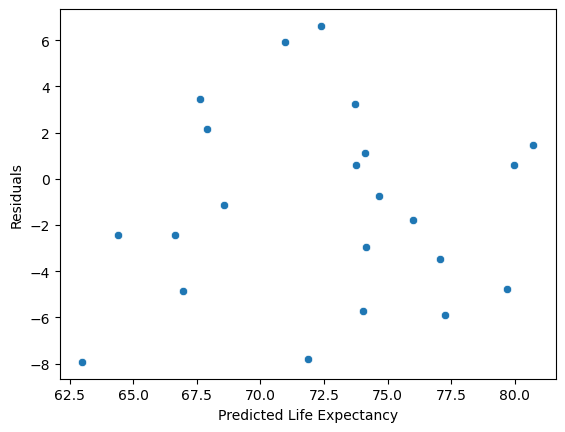

                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          3.023e+04
Date:                Sat, 19 Nov 2022   Prob (F-statistic):                   4.62e-134
Time:                        23:04:21   Log-Likelihood:                         -317.28
No. Observations:                 109   AIC:                                      636.6
Df Residuals:                     108   BIC:                                      639.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [51]:
#Used log transformation because data showed strong log(x) type, diminishing returns curve
X = np.log(df_h3["Gross national income (GNI) per capita"].to_numpy().reshape(-1,1))
y = (df_h3["Life Expectancy"])
sns.regplot(x = X,y = y).set(xlabel='Gross National Income', ylabel='Life Expectancy')
plt.show()
schooling_train, schooling_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2, random_state=94)
model_h3 = LinearRegression().fit(schooling_train,exp_train)
train_predictions = model_h3.predict(schooling_train)
test_predictions = model_h3.predict(schooling_test)
train_residuals = exp_train - train_predictions
test_residuals = exp_test - test_predictions
print("Slope of Model:",model_h3.coef_,"\nIntercept of Model:",model_h3.intercept_)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse,)
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()
OLS_model_h3 = sm.OLS(y, X).fit()
print(OLS_model_h3.summary())
print("\nRight-sided P-Value at 97.5% CL:",OLS_model_h3.t_test(1).pvalue)

Our linear regression yields an R squared value of 0.996, suggesting very strong correlation between the log GNI per capita of a country and that country's life expectancy. Our train RMSE is lower than our test RMSE which suggests that our model may be overfitting. Additionally, when running a correlation test to analyze our hypothesis, we can reject the null hypothesis and predict that countries with higher gross national incomes have higher life expectancies with a confidence level of 97.5%. Because our two-sided test with CL 95% yields a p-value of approximately 0, we can conclude that our right-side test would have the same p-value with a CL of 97.5%. This gives us a type I error probability of 2.5%. The model intercepts predicts that a country with a GNI of 1 would have a life expectancy of 23.82 years. The model also predicts that each e multiple increase in a country's GNI per capita will increase their life expectancy by 5.3 years.

## Are happier people living longer?
   * H0: A country’s average happiness does not affect their citizens’ life expectancies.
   * HA: People from countries with higher happiness levels live longer. 

In [60]:
#setup and run regression
X = df_final["happiness_index"].to_numpy().reshape(-1,1)
y = df_final["Life Expectancy"]
happy_train, happy_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2)
model_h4 = LinearRegression().fit(happy_train,exp_train)
print("Slope of Model:",model_h4.coef_,"\nIntercept of Model:",model_h4.intercept_)

#get errors
train_residuals = exp_train - model_h3.predict(happy_train)
test_residuals = exp_test - model_h3.predict(happy_test)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse,)

#plot regression
# sns.regplot(x = X,y = y).set(xlabel='Happiness', ylabel='Life Expectancy')
OLS_model_h4 = sm.OLS(y, X).fit()
print(OLS_model_h4.summary())

Slope of Model: [5.27892563] 
Intercept of Model: 44.15831808330698
Train RMSE: 20.729270501781894 
Test RMSE: 21.027715286174974
                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              6484.
Date:                Sat, 19 Nov 2022   Prob (F-statistic):                    2.93e-98
Time:                        23:05:13   Log-Likelihood:                         -400.47
No. Observations:                 109   AIC:                                      802.9
Df Residuals:                     108   BIC:                                      805.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                         

The model that we have here gives us a t-statistic of 80 and a p-value of 0, indicating that this model is spooky and that we can safely reject the null hypothesis. Thus, there is a correlation between happiness and life expectancies for the countries in our dataset. 

Given that train RMSE < test RMSE, we are not overfitting either. The slope of 5 is also rather significant; a unit increase in happiness results in a half decade increase in life.  

## Do people in countries with UHC (Universal Health Care) live longer?
   * H0: People from countries with UHC live as long as people from countries without UHC. 
   * HA: People from countries with UHC live longer than people from countries without UHC.

Median Life Expectancy of Countries without UHC: 71.61 years
Median Life Expectancy of Countries with UHC: 77.46 years
Sample Difference in the Medians: 5.85 years


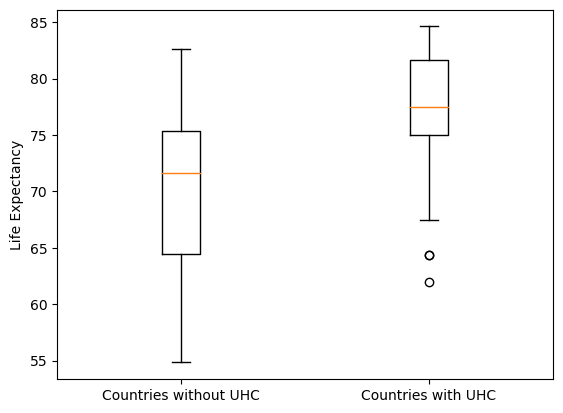

In [53]:
X = df_final["has_uhc"]
y = df_final["Life Expectancy"]

# Life Expectancy datasets according to presence of UHC
y_has_uhc = y[X == 1.0]
y_no_uhc = y[X != 1.0]

# Boxplot
fig, ax = plt.subplots()
ax.boxplot([y_no_uhc, y_has_uhc])
plt.xticks([1, 2], ["Countries without UHC", "Countries with UHC"])
plt.ylabel("Life Expectancy")
plt.show

# Sample Difference
print("Median Life Expectancy of Countries without UHC:", round(y_no_uhc.median(),2), "years")
print("Median Life Expectancy of Countries with UHC:", y_has_uhc.median(), "years")
sample_diff = round(y_has_uhc.median() - y_no_uhc.median(), 2)
print("Sample Difference in the Medians:", sample_diff, "years")

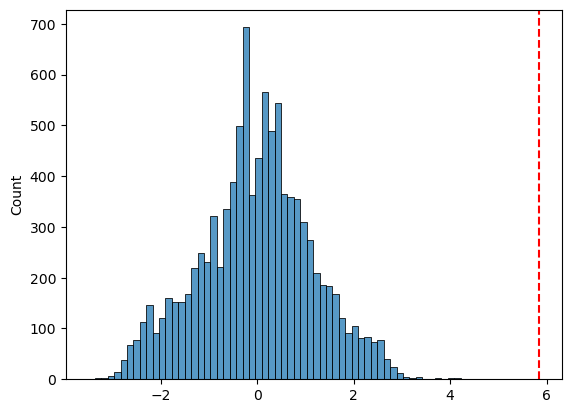

In [54]:
# Permutation Test
perm_diff = np.zeros(10000)
for i in range(10000):
    perm_X = np.random.choice(X, X.size, replace = False)
    perm_y_has_uhc = y[perm_X == 1.0]
    perm_y_no_uhc = y[perm_X != 1.0]
    perm_diff[i] = round(perm_y_has_uhc.median() - perm_y_no_uhc.median(), 2)

# Plot result
sns.histplot(perm_diff)
plt.axvline(sample_diff, color='r', ls='--')

In [55]:
# Interpretation
perm_mean = perm_diff.mean()
perm_std = perm_diff.std()
std_diff = (sample_diff - perm_mean)/perm_std

print("Mean:", round(perm_mean, 2))
print("Standard Deviation:", round(perm_std, 2))
print("Sample difference is", round(std_diff, 2), "standard deviations away from the mean")
print("p-value:", stats.norm.sf(std_diff))

Mean: -0.02
Standard Deviation: 1.17
Sample difference is 5.03 standard deviations away from the mean
p-value: 2.413555836945204e-07


The p-value is significantly less than the significance level of 0.05, so we reject the null hypothesis that people from countries with UHC live as long as people from countries without UHC.

## Multivariate Regression Model

In [56]:
def nans(df): return df[df.isnull().any(axis=1)]
nans(df_final)

,Country,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development


In [59]:
data = df_final.iloc[:,2:]
expected = df_final["Life Expectancy"]
model = LinearRegression().fit(data,expected)
predicted = model.predict(data)
residuals = predicted-expected
mse = np.mean((residuals)**2)
slopes = pd.DataFrame(data = model.coef_.reshape(1,9),columns = df_final.iloc[:,2:].columns)
print ("\nMSE:",mse,"\nIntercept:",model.intercept_,"\nSlopes:")
slopes.head()


MSE: 7.834780151120987 
Intercept: 65.03187207354259 
Slopes:


,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
0,-0.064082,0.216492,-0.000046,0.002795,0.000515,1.062475,0.995671,-0.403023,2.611367


## Graphs
- Reisdual error plot

[Text(0.5, 0, 'Predicted Life Expectancy'), Text(0, 0.5, 'Residuals')]

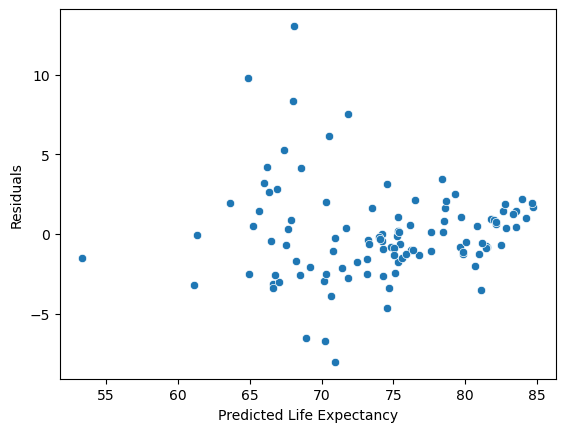

In [21]:
sns.scatterplot(x = predicted, y = residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')

## The Perfect Country

In [66]:
slopes.head()

,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
0,-0.064082,0.216492,-0.000046,0.002795,0.000515,1.062475,0.995671,-0.403023,2.611367


In [65]:
#Find Minimum Value Country for Negative Coefficients and Maximum Value Countries for Positive Coefficients
df_final.head()

,Country,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
0,Albania,78.686,2.29,11.286455,14131.11039,47.51,3360.0,1.0,5.117,11.4,3
1,United Arab Emirates,78.120,0.46,12.694030,62573.59181,62.03,3314.0,1.0,6.561,18.5,4
2,Argentina,76.813,5.32,11.147269,20925.26814,109.39,3307.0,1.0,5.929,15.7,4
3,Armenia,75.224,1.69,11.330300,13157.99390,45.64,2997.0,0.0,5.283,19.9,3
4,Australia,83.200,0.89,12.726820,49238.43335,121.61,3391.0,1.0,7.183,8.6,4


In [ ]:
for 

# Evaluation of Significance

# Interpretation and Conclusions

# Data Limitations

Identify any potential problems with your dataset.

As briefly mentioned in the data description, certain countries lack updated statistics, or any statistics for that matter, which may lead to inaccuracies in our analysis and reduces the number of usable countries in our data. It is also important to note that certain geographic regions are countries to certain organizations and not countries to others. This problem of classification extends to territories, like French Guiana, Crown Dependencies, etc. Our dataset may also have some variates that are too highly correlated, see the matrix below, which leads to a model that may be harder to interpret.

# Source Code

# Acknowledgements